# Air Quality Forecasting with Deep Learning

**Goal**: Predict CO (Carbon Monoxide) concentration 12 hours ahead using air quality sensor data  
**Dataset**: AirQualityUCI - Hourly measurements from March 2004 to April 2005  
**Models**: LSTM, N-BEATSx, and TFT for multi-step time series forecasting

---

## Overview

This notebook compares multiple deep learning architectures for air quality forecasting. The investigated models include:

**Recurrent Networks & Transformers:**
- **LSTM** (Long Short-Term Memory) - Captures long-term temporal dependencies
- **TFT** (Temporal Fusion Transformer) - Attention-based multi-horizon forecasting

**Basis Expansion Models:**
- **N-BEATSx** (Neural Basis Expansion Analysis) - Interpretable hierarchical forecasting

## Workflow

1. **Data Preparation** - Load, clean, and preprocess the UCI Air Quality dataset
2. **Exploratory Analysis** - Visualize temporal patterns and sensor correlations
3. **Feature Engineering** - Create sliding windows and normalize sensor readings
4. **Model Training** - Implement and optimize each architecture with proper validation
5. **Evaluation** - Compare performance using MAE and RMSE metrics

## 1. Environment Setup

Import required libraries for data processing, visualization, and deep learning models.

In [113]:
import os
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

In [114]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [115]:
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Data Loading and Preprocessing

Load the UCI Air Quality dataset and prepare it for time series forecasting by:
- Handling missing values (marked as -200)
- Creating datetime index from separate date/time columns  
- Removing columns with excessive missing data (NMHC)
- Interpolating remaining gaps using time-based method

In [143]:
#DATA_PATH = "C:/Users/khihe/OneDrive/Desktop/Seminar(deep learning)/air+quality/AirQualityUCI.csv"
#DATA_PATH = "C:/Users/danie/OneDrive/Desktop/AirQualityUCI.csv"
DATA_PATH = "AirQualityUCI.csv"

df = pd.read_csv(
    DATA_PATH,
    sep=';',
    decimal=',',
    encoding='latin1'
)
# Mark -200 as missing and remove empty columns
df = df.replace(-200, np.nan)
df = df.dropna(axis=1, how='all')

df["Datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H.%M.%S",
    errors="coerce"
)

df = df.dropna(subset=["Datetime"])
df = df.set_index("Datetime").sort_index()
df = df.drop(columns=["Date", "Time"])

# Remove column with an extremely high number of missing values and interpolation as time 
df = df.drop(columns=["NMHC(GT)"])
df = df.interpolate(method="time")
df = df.dropna() 

## 2. Data Quality Check

Verify data cleaning was successful - check for missing values and inspect
data structure

In [144]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   C6H6(GT)       9357 non-null   float64
 3   PT08.S2(NMHC)  9357 non-null   float64
 4   NOx(GT)        9357 non-null   float64
 5   PT08.S3(NOx)   9357 non-null   float64
 6   NO2(GT)        9357 non-null   float64
 7   PT08.S4(NO2)   9357 non-null   float64
 8   PT08.S5(O3)    9357 non-null   float64
 9   T              9357 non-null   float64
 10  RH             9357 non-null   float64
 11  AH             9357 non-null   float64
dtypes: float64(12)
memory usage: 950.3 KB


CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [145]:
df.describe()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,2.130603,1103.059741,10.179155,942.142620,241.922197,832.758897,109.632094,1453.298814,1032.544298,18.233408,49.191386,1.019621
std,1.431736,218.196346,7.503812,267.866611,204.315075,255.709833,46.462311,343.206131,404.447613,8.781791,17.194506,0.402203
min,0.100000,647.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,1.100000,938.000000,4.500000,736.000000,96.000000,654.000000,76.000000,1227.000000,733.000000,11.700000,35.800000,0.732300
50%,1.800000,1067.000000,8.300000,910.012987,180.000000,804.000000,104.917526,1460.000000,970.000000,17.600000,49.600000,0.989500
75%,2.900000,1239.000000,14.100000,1119.000000,326.000000,968.000000,136.314685,1668.000000,1293.000000,24.300000,62.300000,1.306700
max,11.900000,2040.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


<hr>

## 3. Exploratory Data Analysis

Visualize the target variable (CO concentration) over time to understand:
- Temporal patterns and seasonality
- Value ranges and outliers  
- Correlations between sensors
<hr>

<Axes: title={'center': 'CO(GT) over time'}, xlabel='Datetime'>

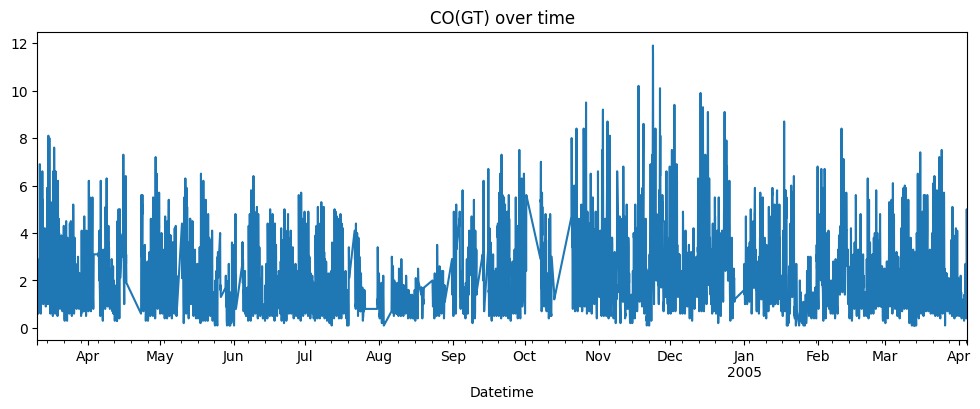

In [146]:
df["CO(GT)"].plot(figsize=(12,4), title="CO(GT) over time")

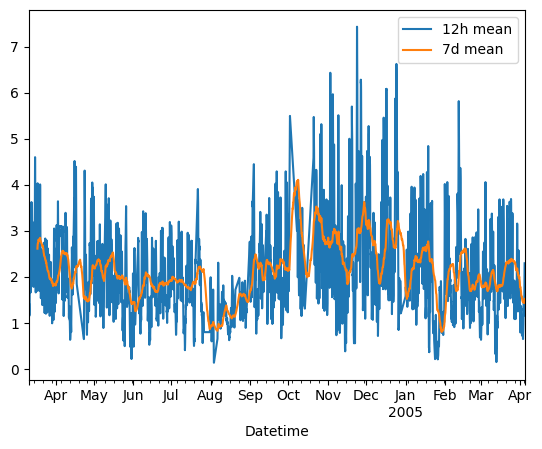

In [120]:
df["CO(GT)"].rolling(12).mean().plot(label="12h mean")
df["CO(GT)"].rolling(168).mean().plot(label="7d mean")
plt.legend()

<Axes: >

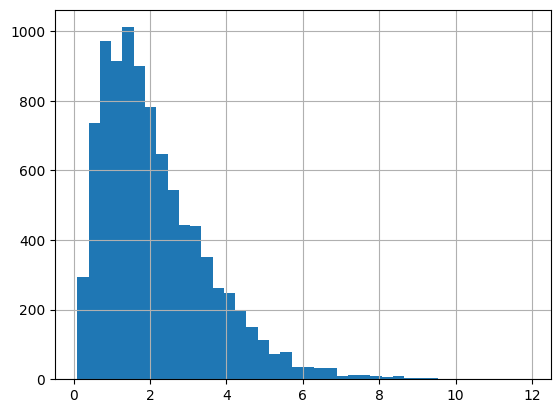

In [121]:
df["CO(GT)"].hist(bins=40)

<Axes: >

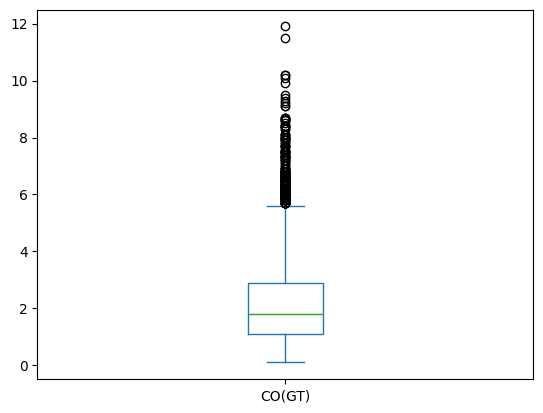

In [122]:
df["CO(GT)"].plot.box()

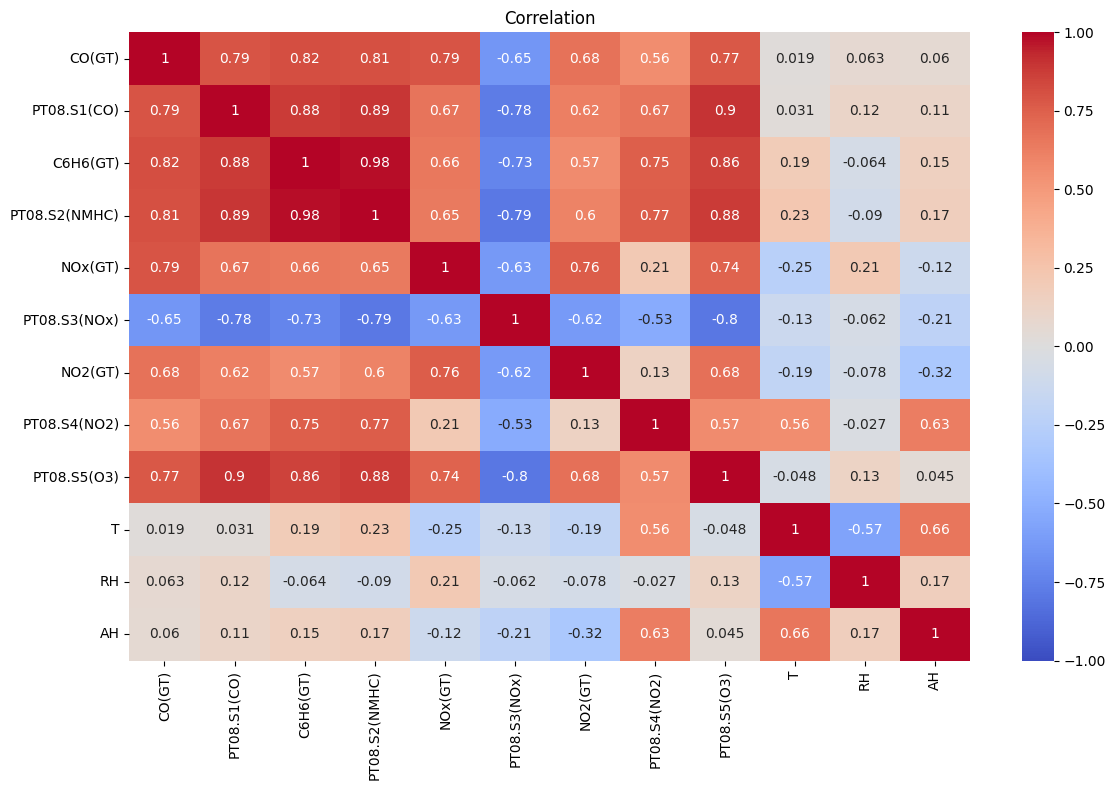

In [123]:
cols = ["CO(GT)", "PT08.S1(CO)", "C6H6(GT)", "PT08.S2(NMHC)",
        "NOx(GT)", "PT08.S3(NOx)", "NO2(GT)", "PT08.S4(NO2)",
        "PT08.S5(O3)", "T", "RH", "AH"]

corr_data = df[cols].apply(pd.to_numeric, errors="coerce").dropna()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_data.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation")
plt.tight_layout()
plt.show()


## 4. Time-aware split (70/15/15)
No shuffling.


In [124]:
n = len(df)

train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_df = df.iloc[:train_end]
val_df   = df.iloc[train_end:val_end]
test_df  = df.iloc[val_end:]

print(train_df.index.min(), "→", train_df.index.max(), "(Train)")
print(val_df.index.min(),   "→", val_df.index.max(), "(Validation)")
print(test_df.index.min(),  "→", test_df.index.max(), "(Test)")

2004-03-10 18:00:00 → 2004-12-08 14:00:00 (Train)
2004-12-08 15:00:00 → 2005-02-05 02:00:00 (Validation)
2005-02-05 03:00:00 → 2005-04-04 14:00:00 (Test)



## 5. Impute, pick target/features, and scale


In [125]:
TARGET = "CO(GT)"
feature_cols = [c for c in train_df.columns if c != TARGET]

x_scaler = MinMaxScaler() 
y_scaler = MinMaxScaler()

x_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET]])

X_train = x_scaler.transform(train_df[feature_cols])
y_train = y_scaler.transform(train_df[[TARGET]]).reshape(-1)

X_val = x_scaler.transform(val_df[feature_cols])
y_val = y_scaler.transform(val_df[[TARGET]]).reshape(-1)

X_test = x_scaler.transform(test_df[feature_cols])
y_test = y_scaler.transform(test_df[[TARGET]]).reshape(-1)


## 6. Sliding windows (supervised framing)
Given `LOOKBACK` past steps, predict the next step (`HORIZON=1`).


In [126]:
LOOKBACK = 168   #  7 Days
HORIZON  = 12    #  12h Forecast

# Window function
def make_windows(X, y, lookback, horizon):
    Xw, yw = [], []
    n = len(y)

    for t in range(lookback, n - horizon + 1):
        Xw.append(X[t - lookback:t, :])
        yw.append(y[t:t + horizon])

    return np.array(Xw), np.array(yw)
    
X_train_w, y_train_w = make_windows(X_train, y_train, LOOKBACK, HORIZON)
X_val_w,   y_val_w   = make_windows(X_val,   y_val,   LOOKBACK, HORIZON)
X_test_w,  y_test_w  = make_windows(X_test,  y_test,  LOOKBACK, HORIZON)

# Check shapes
print("Train:", X_train_w.shape, y_train_w.shape)
print("Val:  ", X_val_w.shape,   y_val_w.shape)
print("Test: ", X_test_w.shape,  y_test_w.shape)

Train: (6370, 168, 11) (6370, 12)
Val:   (1225, 168, 11) (1225, 12)
Test:  (1225, 168, 11) (1225, 12)



# Modeling:



## 7. Baseline: persistence
Predict next value = last value in the input window.


In [127]:
def metrics(true, pred, scaler=None):
    true = np.asarray(true)
    pred = np.asarray(pred)

    # flatten over all horizons
    true_f = true.reshape(-1, 1)
    pred_f = pred.reshape(-1, 1)

    if scaler is not None:
        true_inv = scaler.inverse_transform(true_f).ravel()
        pred_inv = scaler.inverse_transform(pred_f).ravel()
    else:
        true_inv = true_f.ravel()
        pred_inv = pred_f.ravel()

    mae = mean_absolute_error(true_inv, pred_inv)
    rmse = math.sqrt(mean_squared_error(true_inv, pred_inv))
    return mae, rmse

def persistence_from_y(y_scaled_1d, lookback, horizon):
    """
    y_scaled_1d: 1D array (scaled target) for a split (train OR val OR test)
    Returns:
      y_true_w: (N, horizon)
      y_pred_w: (N, horizon) persistence forecasts
    """
    y_true_w = []
    y_pred_w = []
    n = len(y_scaled_1d)

    for t in range(lookback, n - horizon + 1):
        last_val = y_scaled_1d[t - 1]                # last observed before horizon
        y_true_w.append(y_scaled_1d[t:t + horizon])  # true future window
        y_pred_w.append(np.repeat(last_val, horizon))

    return np.array(y_true_w), np.array(y_pred_w)

# build persistence baseline on VAL split
y_true_val_p, y_pred_val_p = persistence_from_y(y_val, LOOKBACK, HORIZON)

val_mae_p, val_rmse_p = metrics(y_true_val_p, y_pred_val_p, scaler=y_scaler)
print(f"Persistence baseline -> Val MAE: {val_mae_p:.4f}, RMSE: {val_rmse_p:.4f}")

y_true_test_p, y_pred_test_p = persistence_from_y(y_test, LOOKBACK, HORIZON)
test_mae_p, test_rmse_p = metrics(y_true_test_p, y_pred_test_p, scaler=y_scaler)
print(f"Persistence baseline -> Test MAE: {test_mae_p:.4f}, RMSE: {test_rmse_p:.4f}")
baseline_results = {"MAE": val_mae_p, "RMSE": val_rmse_p}

Persistence baseline -> Val MAE: 1.1956, RMSE: 1.7146
Persistence baseline -> Test MAE: 1.1807, RMSE: 1.6128


## 8. LSTM Model 


In [128]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_w.shape[1], X_train_w.shape[2])),
    #LSTM(64, return_sequences=True, input_shape=(LOOKBACK, NFEATS)),
    #Dropout(0.15), 
    LSTM(32, return_sequences=False),
    #Dropout(0.15), 
    #Dense(32, activation="relu"), # habe ich einmal ohne diese Zeile run gelassen damit ich sehe wann ich bessere Ergebnise bekomme.
    Dense(HORIZON)
], name="LSTM_Model")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mae"
)
model.summary()

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    restore_best_weights=True
)
history = model.fit(
    X_train_w, y_train_w,
    validation_data=(X_val_w, y_val_w),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=2
)
y_val_pred  = model.predict(X_val_w,  verbose=0)
y_test_pred = model.predict(X_test_w, verbose=0)

y_train_pred = model.predict(X_train_w, verbose=0)

#  Metrics (inverse-transform to original CO(GT))
def metrics_multistep(y_true, y_pred, scaler):
    # flatten all horizons
    true_f = y_true.reshape(-1, 1)
    pred_f = y_pred.reshape(-1, 1)
    true_inv = scaler.inverse_transform(true_f).ravel()
    pred_inv = scaler.inverse_transform(pred_f).ravel()
    mae  = mean_absolute_error(true_inv, pred_inv)
    rmse = math.sqrt(mean_squared_error(true_inv, pred_inv))
    return mae, rmse

val_mae, val_rmse   = metrics_multistep(y_val_w,  y_val_pred,  y_scaler)
test_mae, test_rmse = metrics_multistep(y_test_w, y_test_pred, y_scaler)

train_mae, train_rmse = metrics_multistep(y_train_w, y_train_pred, y_scaler)


print(f"LSTM -> Val  MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")
print(f"LSTM -> Test MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")

print(f"LSTM -> Train MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}")


# Save results
if "results" not in globals():
    results = {}
results["LSTM"] = {
    "val_mae": val_mae, 
    "val_rmse": val_rmse, 
    "test_mae": test_mae, 
    "test_rmse": test_rmse
}

/opt/conda/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 168, 64)        │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,268 (126.05 KB)

 Trainable params: 32,268 (126.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2026-02-20 15:56:34.216155: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


100/100 - 3s - 29ms/step - loss: 0.0885 - val_loss: 0.1055
Epoch 2/50
100/100 - 2s - 16ms/step - loss: 0.0769 - val_loss: 0.0908
Epoch 3/50
100/100 - 1s - 15ms/step - loss: 0.0709 - val_loss: 0.0829
Epoch 4/50
100/100 - 2s - 16ms/step - loss: 0.0672 - val_loss: 0.0795
Epoch 5/50
100/100 - 2s - 16ms/step - loss: 0.0647 - val_loss: 0.0795
Epoch 6/50
100/100 - 2s - 16ms/step - loss: 0.0633 - val_loss: 0.0798
Epoch 7/50
100/100 - 2s - 18ms/step - loss: 0.0614 - val_loss: 0.0789
Epoch 8/50
100/100 - 2s - 16ms/step - loss: 0.0597 - val_loss: 0.0786
Epoch 9/50
100/100 - 1s - 14ms/step - loss: 0.0587 - val_loss: 0.0786
Epoch 10/50
100/100 - 1s - 14ms/step - loss: 0.0577 - val_loss: 0.0793
Epoch 11/50
100/100 - 2s - 16ms/step - loss: 0.0570 - val_loss: 0.0794
Epoch 12/50
100/100 - 2s - 16ms/step - loss: 0.0564 - val_loss: 0.0806
Epoch 13/50
100/100 - 2s - 17ms/step - loss: 0.0560 - val_loss: 0.0815


2026-02-20 15:56:56.174367: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


LSTM -> Val  MAE: 0.9277, RMSE: 1.2741
LSTM -> Test MAE: 0.8372, RMSE: 1.0674
LSTM -> Train MAE: 0.7047, RMSE: 0.9918


### Training Loss curve

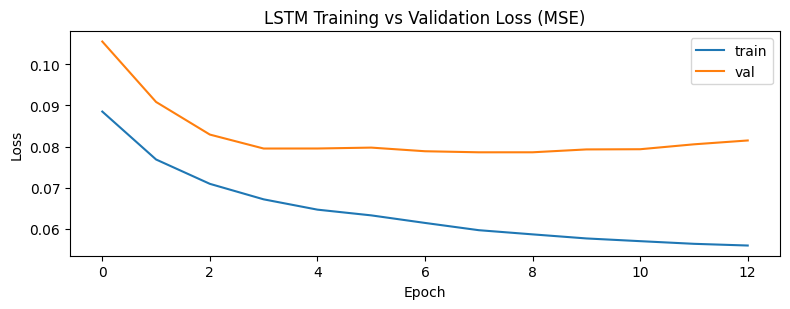

In [129]:
plt.figure(figsize=(8,3.2))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('LSTM Training vs Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Prediction vs. Actual 

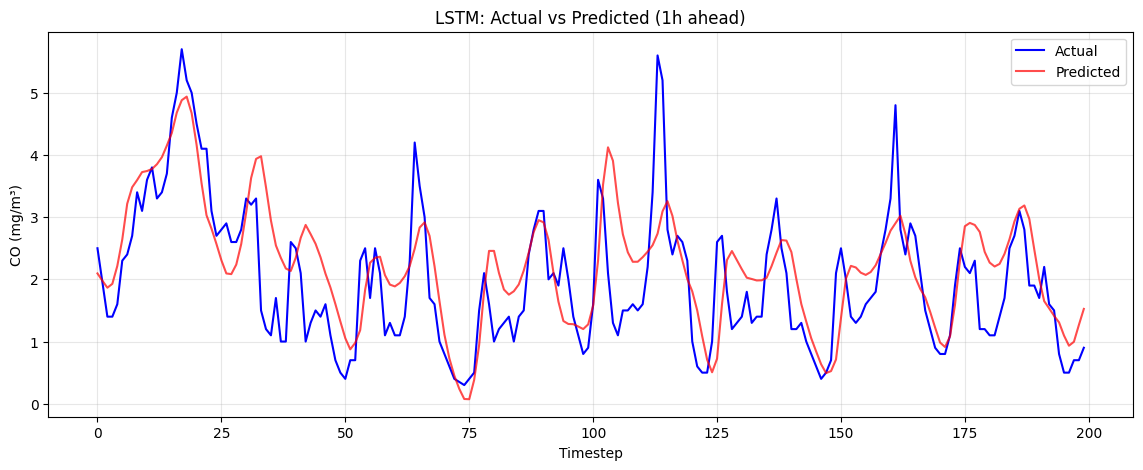

In [130]:
# LSTM: Actual vs Predicted (1h ahead)
y_true_h1 = y_scaler.inverse_transform(y_test_w[:, 0].reshape(-1, 1)).ravel()
y_pred_h1 = y_scaler.inverse_transform(y_test_pred[:, 0].reshape(-1, 1)).ravel()

plt.figure(figsize=(14, 5))
plt.plot(y_true_h1[:200], label='Actual', color='blue')
plt.plot(y_pred_h1[:200], label='Predicted', color='red', alpha=0.7)
plt.xlabel('Timestep')
plt.ylabel('CO (mg/m³)')
plt.title('LSTM: Actual vs Predicted (1h ahead)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 9. N-BEATSx Model 

In [131]:
LOOKBACK         = 168   # 168 hours Lookback
FORECAST_HORIZON = 12    # 12 Hours ahead

X_train = np.asarray(X_train)
X_val   = np.asarray(X_val)
X_test  = np.asarray(X_test)

y_train = np.asarray(y_train).reshape(-1, 1)
y_val   = np.asarray(y_val).reshape(-1, 1)
y_test  = np.asarray(y_test).reshape(-1, 1)

target_idx = df.columns.get_loc("CO(GT)")
cov_indices = [i for i in range(X_train.shape[1]) if i != target_idx]

def make_windows_nbeatsx(X, y, lookback, horizon, target_idx, cov_indices):
    X_nb, X_cov, yw = [], [], []
    n = len(y)
    for t in range(lookback, n - horizon + 1):
        X_nb.append(X[t - lookback:t, target_idx:target_idx+1])
        X_cov.append(X[t - lookback:t + horizon, cov_indices])
        yw.append(y[t:t + horizon, :])
    return np.array(X_nb), np.array(X_cov), np.array(yw)

X_train_nb, X_train_cov, y_train_12 = make_windows_nbeatsx(X_train, y_train, LOOKBACK, FORECAST_HORIZON, target_idx, cov_indices)
X_val_nb,   X_val_cov,   y_val_12   = make_windows_nbeatsx(X_val,   y_val,   LOOKBACK, FORECAST_HORIZON, target_idx, cov_indices)
X_test_nb,  X_test_cov,  y_test_12  = make_windows_nbeatsx(X_test,  y_test,  LOOKBACK, FORECAST_HORIZON, target_idx, cov_indices)

print("Train:", X_train_nb.shape, X_train_cov.shape, y_train_12.shape)
print("Val:  ", X_val_nb.shape,   X_val_cov.shape,   y_val_12.shape)
print("Test: ", X_test_nb.shape,  X_test_cov.shape,  y_test_12.shape)

def nbeatsx_block(residual, x_cov_flat, lookback, forecast_horizon, units, num_fc, name="block"):
    combined = layers.Concatenate(name=f"{name}_concat")([residual, x_cov_flat])
    x = combined
    for i in range(num_fc):
        x = layers.Dense(units, activation="relu", name=f"{name}_fc{i}")(x)
        x = layers.Dropout(0.1, name=f"{name}_drop{i}")(x)
    theta = layers.Dense(units, activation=None, name=f"{name}_theta")(x)
    backcast = layers.Dense(lookback, activation=None, name=f"{name}_backcast")(theta)
    forecast = layers.Dense(forecast_horizon, activation=None, name=f"{name}_forecast")(theta)
    return backcast, forecast

def build_nbeatsx(lookback, forecast_horizon, n_cov, num_stacks, num_blocks, units, num_fc):
    y_inp = layers.Input(shape=(lookback, 1), name="target_input")
    x_inp = layers.Input(shape=(lookback + forecast_horizon, n_cov), name="covariate_input")
    residual   = layers.Flatten(name="flatten_target")(y_inp)
    x_cov_flat = layers.Flatten(name="flatten_cov")(x_inp)

    all_stack_forecasts = []
    for s in range(num_stacks):
        block_forecasts = []
        for b in range(num_blocks):
            backcast, forecast = nbeatsx_block(
                residual=residual,
                x_cov_flat=x_cov_flat,
                lookback=lookback,
                forecast_horizon=forecast_horizon,
                units=units,
                num_fc=num_fc,
                name=f"stack{s}_block{b}"
            )
            residual = layers.Subtract(name=f"stack{s}_residual{b}")([residual, backcast])
            block_forecasts.append(forecast)

        stack_forecast = layers.Add(name=f"stack{s}_forecast_sum")(block_forecasts)
        all_stack_forecasts.append(stack_forecast)

    final_forecast = layers.Add(name="final_forecast_sum")(all_stack_forecasts)
    final_forecast = layers.Reshape((forecast_horizon, 1), name="forecast_reshape")(final_forecast)

    return Model(inputs=[y_inp, x_inp], outputs=final_forecast, name="NBEATSx")

N_COV = X_train_cov.shape[2]

nbeatsx_model = build_nbeatsx(
    lookback=LOOKBACK,
    forecast_horizon=FORECAST_HORIZON,
    n_cov=N_COV,
    num_stacks=2,
    num_blocks=2,
    units=128,
    num_fc=4
)

nbeatsx_model.summary()

nbeatsx_model.compile(optimizer=Adam(5e-4), loss="mse")
history = nbeatsx_model.fit(
    [X_train_nb, X_train_cov], y_train_12,
    validation_data=([X_val_nb, X_val_cov], y_val_12),
    epochs=100,
    batch_size=32,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)

def metrics(y_true, y_pred, scaler=None):
    y_true = y_true.reshape(-1, 1)
    y_pred = y_pred.reshape(-1, 1)
    if scaler is not None:
        y_true = scaler.inverse_transform(y_true)
        y_pred = scaler.inverse_transform(y_pred)
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

y_pred_val   = nbeatsx_model.predict([X_val_nb,   X_val_cov],   verbose=0)
y_pred_train = nbeatsx_model.predict([X_train_nb, X_train_cov], verbose=0)
y_pred_test  = nbeatsx_model.predict([X_test_nb,  X_test_cov],  verbose=0)

val_mae,   val_rmse   = metrics(y_val_12,   y_pred_val,   scaler=globals().get("y_scaler", None))
train_mae, train_rmse = metrics(y_train_12, y_pred_train, scaler=globals().get("y_scaler", None))
test_mae,  test_rmse  = metrics(y_test_12,  y_pred_test,  scaler=globals().get("y_scaler", None))

print(f"N-BEATSx Validation -> MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}")
print(f"N-BEATSx Train      -> MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}")
print(f"N-BEATSx Test       -> MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}")


Train: (6370, 168, 1) (6370, 180, 10) (6370, 12, 1)
Val:   (1225, 168, 1) (1225, 180, 10) (1225, 12, 1)
Test:  (1225, 168, 1) (1225, 180, 10) (1225, 12, 1)


Model: "NBEATSx"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None, 168, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ covariate_input     │ (None, 180, 10)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_target      │ (None, 168)       │          0 │ target_input[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_cov         │ (None, 1800)      │          0 │ covariate_input[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_conc… │ (None, 1968)      │          0 │ flatten_target[0… │
│ (Concatenate)       │                   │            │ flatten_cov[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_fc0   │ (None, 128)       │    252,032 │ stack0_block0_co… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_drop0 │ (None, 128)       │          0 │ stack0_block0_fc… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_fc1   │ (None, 128)       │     16,512 │ stack0_block0_dr… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_drop1 │ (None, 128)       │          0 │ stack0_block0_fc… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_fc2   │ (None, 128)       │     16,512 │ stack0_block0_dr… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_drop2 │ (None, 128)       │          0 │ stack0_block0_fc… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_fc3   │ (None, 128)       │     16,512 │ stack0_block0_dr… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_drop3 │ (None, 128)       │          0 │ stack0_block0_fc… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_theta │ (None, 128)       │     16,512 │ stack0_block0_dr… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_back… │ (None, 168)       │     21,672 │ stack0_block0_th… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_residual0    │ (None, 168)       │          0 │ flatten_target[0… │
│ (Subtract)          │                   │            │ stack0_block0_ba… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block1_conc… │ (None, 1968)      │          0 │ stack0_residual0

 Total params: 1,343,528 (5.13 MB)

 Trainable params: 1,343,528 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2026-02-20 15:57:15.085048: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


199/200 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0294

2026-02-20 15:57:22.393217: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0292 - val_loss: 0.0094
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0067 - val_loss: 0.0087
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0058 - val_loss: 0.0082
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0051 - val_loss: 0.0091
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0048 - val_loss: 0.0090
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0046 - val_loss: 0.0092


2026-02-20 15:57:40.505174: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


N-BEATSx Validation -> MAE: 0.8160, RMSE: 1.0666
N-BEATSx Train      -> MAE: 0.5904, RMSE: 0.7678
N-BEATSx Test       -> MAE: 0.6573, RMSE: 0.8252


import sys
!{sys.executable} -m pip install --force-reinstall numpy==1.26.4
!{sys.executable} -m pip install --force-reinstall pandas==2.1.4
!{sys.executable} -m pip install -U "protobuf>=5.28.0,<6" --force-reinstall --no-cache-dir

### Training Loss curve

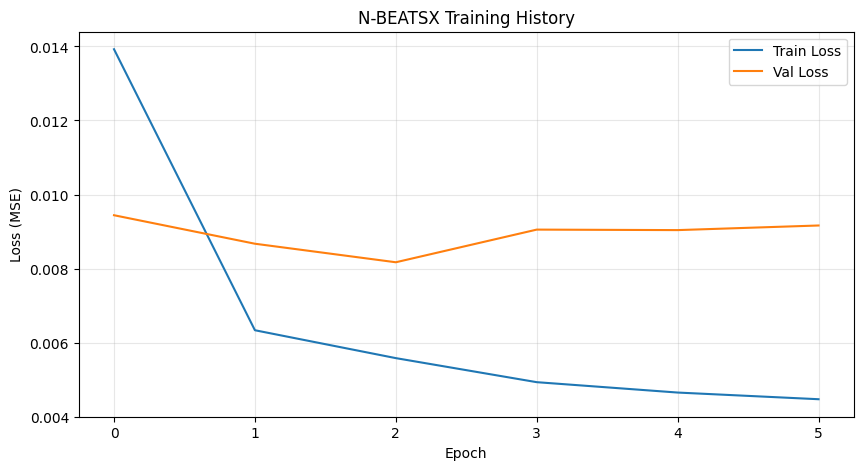

In [132]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('N-BEATSX Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Prediction vs. Actual 

2026-02-20 15:57:56.067324: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


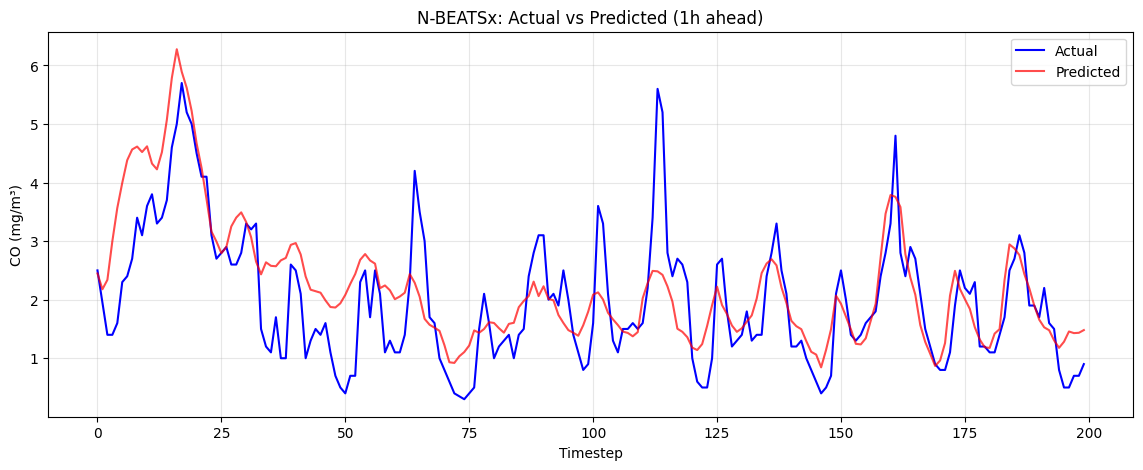

In [133]:
y_pred_test_nb = nbeatsx_model.predict([X_test_nb, X_test_cov], verbose=0)


y_true_h1 = y_scaler.inverse_transform(y_test_12[:, 0].reshape(-1, 1)).ravel()
y_pred_h1 = y_scaler.inverse_transform(y_pred_test_nb[:, 0, 0].reshape(-1, 1)).ravel()

plt.figure(figsize=(14, 5))
plt.plot(y_true_h1[:200], label='Actual', color='blue')
plt.plot(y_pred_h1[:200], label='Predicted', color='red', alpha=0.7)
plt.xlabel('Timestep')
plt.ylabel('CO (mg/m³)')
plt.title('N-BEATSx: Actual vs Predicted (1h ahead)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## comparison LSTM & N-BEATSx

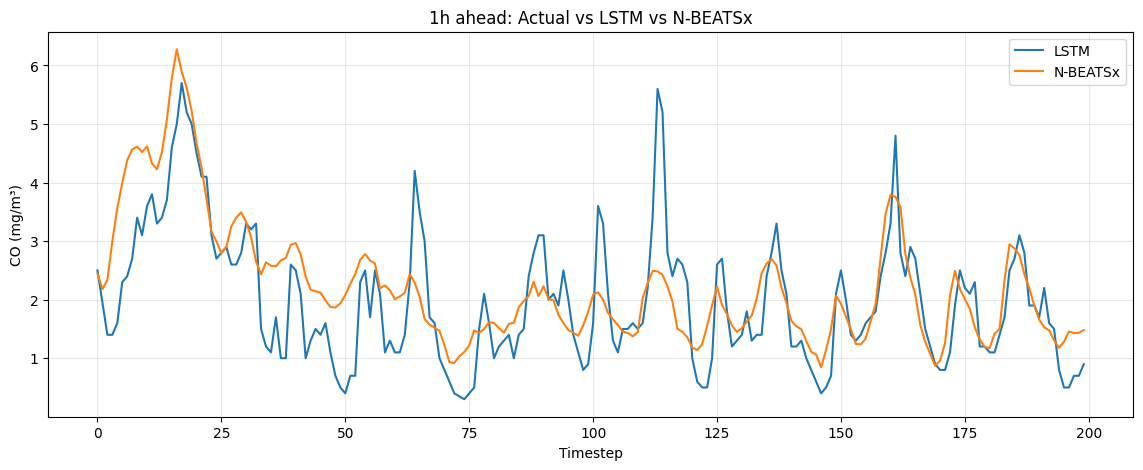

In [ ]:
y_true = y_scaler.inverse_transform(y_test_w[:, 0].reshape(-1, 1)).ravel()
y_lstm = y_scaler.inverse_transform(y_test_w[:, 0].reshape(-1, 1)).ravel()

y_pred_nb = nbeats_model.predict([X_test_nb, X_test_cov], verbose=0) 
y_nb = y_scaler.inverse_transform(y_pred_nb[:, 0, 0].reshape(-1, 1)).ravel()

n = 200
plt.figure(figsize=(14, 5))
plt.plot(y_lstm[:n], label="LSTM")
plt.plot(y_nb[:n], label="N-BEATSx")
plt.xlabel("Timestep")
plt.ylabel("CO (mg/m³)")
plt.title("1h ahead: Actual vs LSTM vs N-BEATSx")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##  Evaluate Results

2026-02-20 15:58:02.413739: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}


Val MAE: 0.8159925119782748


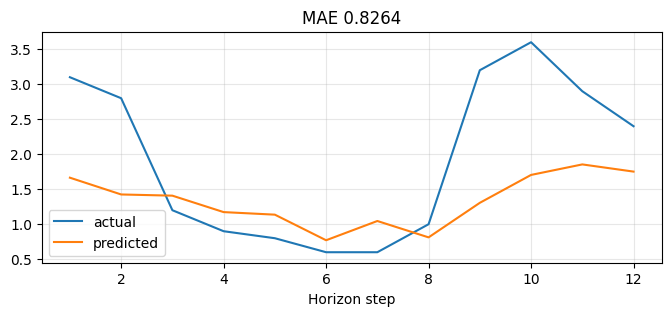

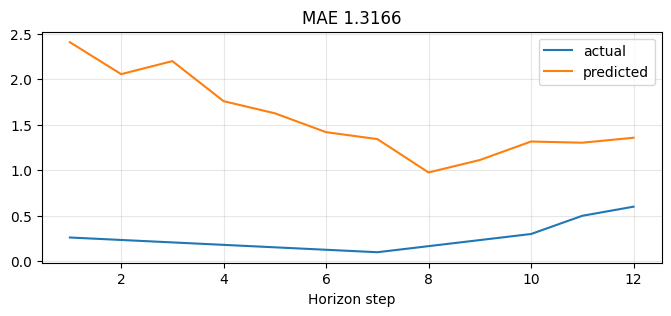

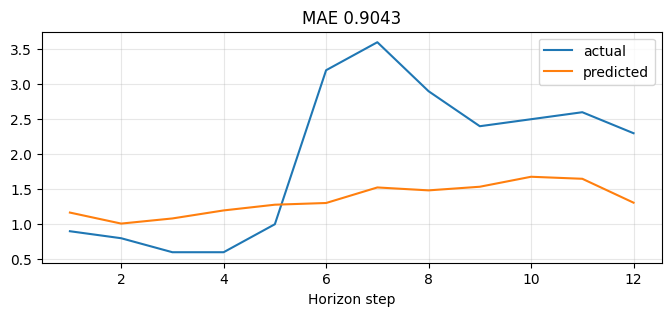

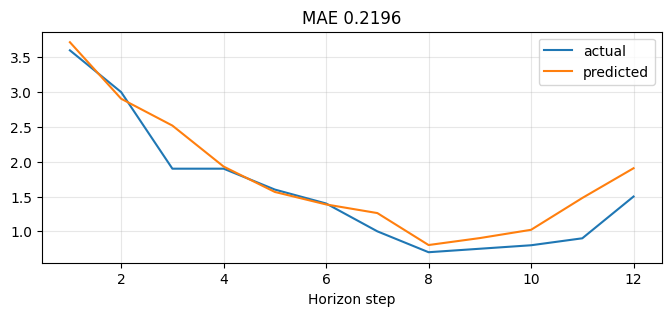

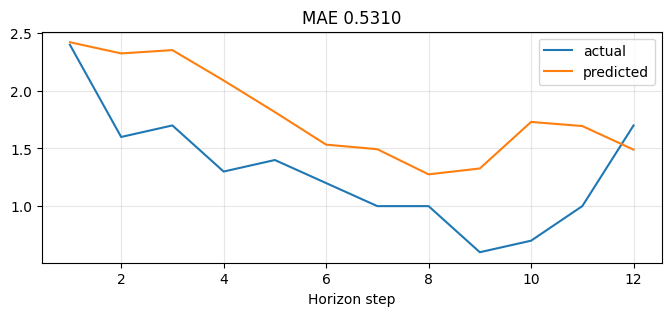

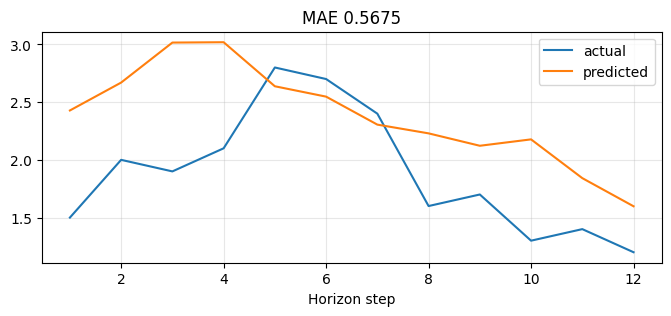

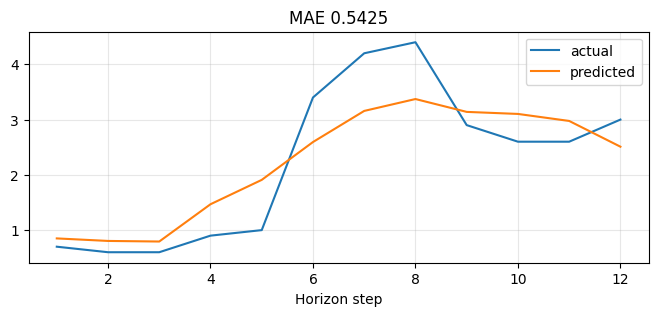

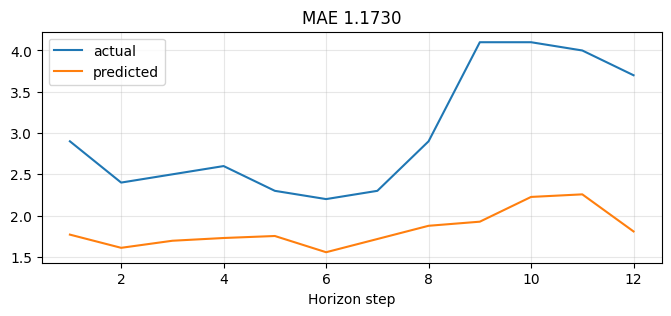

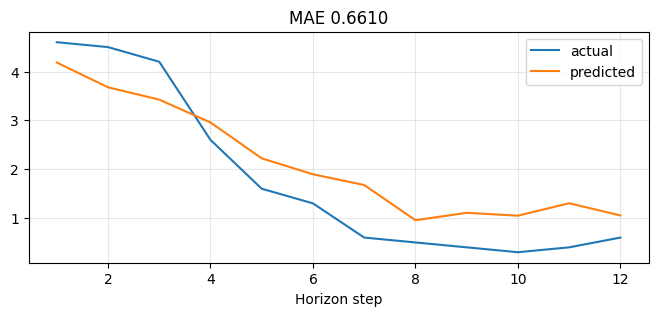

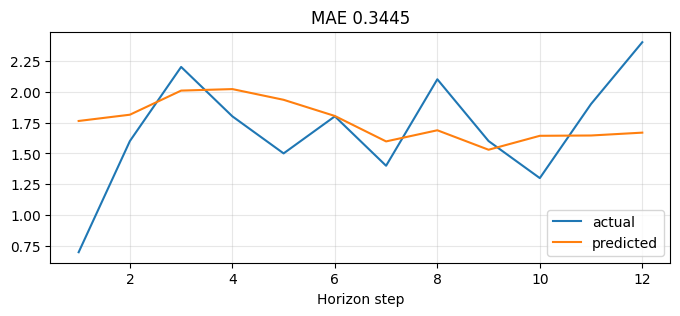

In [135]:
y_pred_val = nbeatsx_model.predict([X_val_nb, X_val_cov], verbose=0)
if y_pred_val.ndim == 3:
    y_pred_val = y_pred_val[:, :, 0]

y_true_val_inv = y_scaler.inverse_transform(y_val_12.reshape(-1, 1)).ravel()
y_pred_val_inv = y_scaler.inverse_transform(y_pred_val.reshape(-1, 1)).ravel()
val_mae = np.mean(np.abs(y_true_val_inv - y_pred_val_inv))
print("Val MAE:", val_mae)

def plot_random_examples(X, y_true, y_pred, n_examples=10):
    rng = np.random.default_rng(42)
    idxs = rng.choice(len(X), size=min(n_examples, len(X)), replace=False)
    for idx in idxs:
        true = y_scaler.inverse_transform(y_true[idx].reshape(-1, 1)).ravel()
        pred = y_scaler.inverse_transform(y_pred[idx].reshape(-1, 1)).ravel()
        loss = np.mean(np.abs(true - pred))
        plt.figure(figsize=(8, 3))
        plt.plot(np.arange(1, len(true)+1), true, label="actual")
        plt.plot(np.arange(1, len(pred)+1), pred, label="predicted")
        plt.title(f"MAE {loss:.4f}")
        plt.xlabel("Horizon step")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

plot_random_examples(X_val_nb, y_val_12, y_pred_val, n_examples=10)

## 10. TFT Model 

2026-02-20 16:02:33.018774: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


TFT Feature Importance Ranking:
      Feature  Importance
           RH    0.254008
  PT08.S5(O3)    0.228321
      NO2(GT)    0.103299
  PT08.S1(CO)    0.082145
      NOx(GT)    0.073952
 PT08.S3(NOx)    0.065237
 PT08.S4(NO2)    0.062720
            T    0.056427
PT08.S2(NMHC)    0.038491
           AH    0.020406
     C6H6(GT)    0.014994


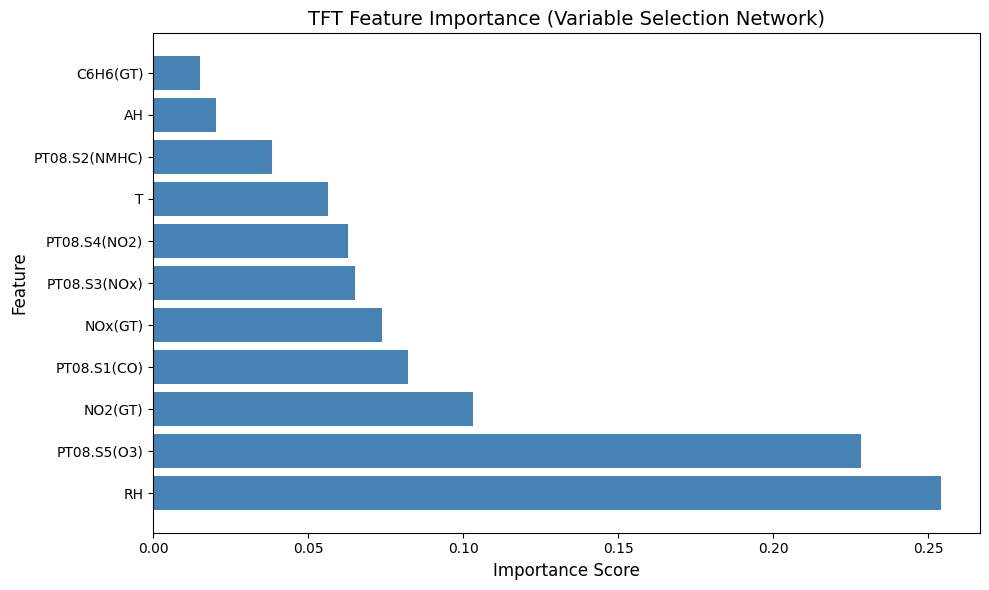

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.4705 - point_loss: 0.2542 - quantiles_loss: 0.2163

2026-02-20 16:02:58.361110: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


100/100 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - loss: 0.4679 - point_loss: 0.2526 - quantiles_loss: 0.2153 - val_loss: 0.0629 - val_point_loss: 0.0231 - val_quantiles_loss: 0.0388 - learning_rate: 5.0000e-04
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0599 - point_loss: 0.0219 - quantiles_loss: 0.0381 - val_loss: 0.0599 - val_point_loss: 0.0224 - val_quantiles_loss: 0.0366 - learning_rate: 5.0000e-04
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0487 - point_loss: 0.0160 - quantiles_loss: 0.0326 - val_loss: 0.0587 - val_point_loss: 0.0216 - val_quantiles_loss: 0.0362 - learning_rate: 5.0000e-04
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0444 - point_loss: 0.0138 - quantiles_loss: 0.0306 - val_loss: 0.0572 - val_point_loss: 0.0209 - val_quantiles_loss: 0.0355 - learning_rate: 5.0000e-04
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0420 - point_loss: 0.0126 - quantiles_loss: 0.0294 - val_loss: 0.0567 - val_point_loss:

Model: "TFT_12H_twohead"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 168, 11)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ variable_selection… │ [(None, 168, 64), │    191,209 │ input_layer_9[0]… │
│ (VariableSelection… │ (None, 168, 11)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 168, 64)   │     33,024 │ variable_selecti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grn_82 (GRN)        │ (None, 168, 64)   │     25,024 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ self_attention      │ [(None, 168, 64), │     16,640 │ grn_82[0][0],     │
│ (MultiHeadAttentio… │ (None, 4, 168,    │            │ grn_82[0][0]      │
│                     │ 168)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 168, 64)   │          0 │ grn_82[0][0],     │
│                     │                   │            │ self_attention[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_layernorm      │ (None, 168, 64)   │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ grn_83 (GRN)        │ (None, 168, 64)   │     25,024 │ attn_layernorm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ select_last_timest… │ (None, 64)        │          0 │ grn_83[0][0]      │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quantiles_raw       │ (None, 36)        │      2,340 │ select_last_time… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ point (Dense)       │ (None, 12)        │        780 │ select_last_time… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quantiles (Reshape) │ (None, 12, 3)     │          0 │ quantiles_raw[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 882,509 (3.37 MB)

 Trainable params: 294,169 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,340 (2.24 MB)

2026-02-20 16:08:55.003652: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Hour+01: p10=0.992, p50=1.905, p90=3.485
Hour+02: p10=1.394, p50=1.981, p90=4.190
Hour+03: p10=0.764, p50=1.871, p90=4.341
Hour+04: p10=0.674, p50=1.974, p90=4.399
Hour+05: p10=0.998, p50=2.473, p90=4.569
Hour+06: p10=0.809, p50=2.383, p90=4.383
Hour+07: p10=0.716, p50=2.407, p90=4.489
Hour+08: p10=0.714, p50=2.344, p90=4.467
Hour+09: p10=0.901, p50=2.528, p90=4.520
Hour+10: p10=0.456, p50=2.334, p90=4.308
Hour+11: p10=0.289, p50=2.599, p90=4.045
Hour+12: p10=0.566, p50=2.233, p90=4.784
TFT (12h) -> Val  MAE: 1.1004, RMSE: 1.4293
TFT (12h) -> Test MAE: 1.0679, RMSE: 1.3572


In [ ]:
LOOKBACK = X_train_w.shape[1]
NFEATS   = X_train_w.shape[2]
HORIZON  = y_train_w.shape[1]   

class GatedLinearUnit(layers.Layer):
    def __init__(self, out_dim):
        super().__init__()
        self.fc = layers.Dense(out_dim)
        self.gate = layers.Dense(out_dim, activation="sigmoid")

    def call(self, x):
        return self.fc(x) * self.gate(x)

class GRN(layers.Layer): 
    def __init__(self, hidden, out_dim, dropout):
        super().__init__()
        self.hidden = hidden
        self.out_dim = out_dim
        self.dropout = dropout
        self.d1 = layers.Dense(hidden, activation="elu")
        #self.d2 = None
        #self.glu = None
        #self.skip = None
        self.ln = layers.LayerNormalization(epsilon=1e-6)
        self.dp = layers.Dropout(dropout)

    def build(self, input_shape):
        in_dim = int(input_shape[-1])
        out_dim = self.out_dim if self.out_dim is not None else in_dim
        self.d2 = layers.Dense(out_dim)
        self.glu = GatedLinearUnit(out_dim)
        self.skip = layers.Dense(out_dim) if in_dim != out_dim else None

    def call(self, x, training=None):
        h = self.d1(x)
        h = self.d2(h)
        h = self.dp(h, training=training)
        h = self.glu(h)
        res = self.skip(x) if self.skip is not None else x
        return self.ln(res + h)

class VariableSelectionNetwork(layers.Layer):
    def __init__(self, n_vars, d_model, hidden, dropout):
        super().__init__()
        self.n_vars = n_vars
        self.d_model = d_model
        self.var_grns = [GRN(hidden=hidden, out_dim=d_model, dropout=dropout) for _ in range(n_vars)]
        self.weight_grn = GRN(hidden=hidden, out_dim=n_vars, dropout=dropout)

    def call(self, x, training=None):
        transformed = []
        for i in range(self.n_vars):
            v = x[:, :, i:i+1]  
            transformed.append(self.var_grns[i](v, training=training))  
        v_stack = tf.stack(transformed, axis=2)

        logits = self.weight_grn(x, training=training)        
        weights = tf.nn.softmax(logits, axis=-1)              

        selected = tf.reduce_sum(v_stack * tf.expand_dims(weights, -1), axis=2)
        return selected, weights

def build_tft_multistep_with_quantiles(input_shape, horizon, d_model, hidden, num_heads, dropout,
                                       quantiles=(0.1, 0.5, 0.9)):
    inp = layers.Input(shape=input_shape)  # (T, F)

    x, var_weights = VariableSelectionNetwork(
        n_vars=input_shape[-1],
        d_model=d_model,
        hidden=hidden,
        dropout=dropout
    )(inp)

    lstm_out = layers.LSTM(d_model, return_sequences=True, dropout=dropout, name="lstm")(x)
    x = GRN(hidden=hidden, out_dim=d_model, dropout=dropout)(lstm_out)

    attn_layer = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=max(1, d_model // num_heads),
        dropout=dropout,
        name="self_attention"
    )
    attn_out, attn_scores = attn_layer(x, x, return_attention_scores=True)
    x = layers.LayerNormalization(epsilon=1e-6, name="attn_layernorm")(x + attn_out)

    x = GRN(hidden=hidden, out_dim=d_model, dropout=dropout)(x)

    x_last = layers.Lambda(lambda t: t[:, -1, :], name="select_last_timestep")(x)

    # Head 1: point forecast (MSE)
    point_out = layers.Dense(horizon, name="point")(x_last)

    # Head 2: quantiles p10/p50/p90 for each horizon step
    Q = len(quantiles)
    q_raw = layers.Dense(horizon * Q, name="quantiles_raw")(x_last)
    q_out = layers.Reshape((horizon, Q), name="quantiles")(q_raw)

    model = Model(inp, outputs={"point": point_out, "quantiles": q_out}, name="TFT_12H_twohead")
    explain_model = Model(inp, [point_out, q_out, var_weights, attn_scores], name="TFT_12H_twohead_explain")
    return model, explain_model

QUANTILES = (0.1, 0.5, 0.9)

tft_model, tft_explain = build_tft_multistep_with_quantiles(
    input_shape=(LOOKBACK, NFEATS),
    horizon=HORIZON,
    d_model=64,
    hidden=128,
    num_heads=4,
    dropout=0.1,
    quantiles=QUANTILES
)

point_pred, q_pred, var_weights, attn_scores = tft_explain.predict(X_val_w[:100], verbose=0)
#predictions, var_weights, attn_scores = tft_explain.predict(X_val_w[:100])
feature_importance = var_weights.mean(axis=(0, 1))

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("TFT Feature Importance Ranking:")
print(importance_df.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('TFT Feature Importance (Variable Selection Network)', fontsize=14)
plt.tight_layout()
plt.show()


def quantile_loss(quantiles=(0.1, 0.5, 0.9)):
    qs = tf.constant(quantiles, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_true = tf.expand_dims(y_true, axis=-1)
        e = y_true - y_pred                     
        q = qs[None, None, :]                   
        return tf.reduce_mean(tf.maximum(q * e, (q - 1.0) * e))
    return loss

tft_model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4, clipnorm=1.0),
    loss={
        "point": "mse",
        "quantiles": quantile_loss(QUANTILES),
    },
    loss_weights={
        "point": 1.0,
        "quantiles": 1.0,  
    }
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=7, min_lr=1e-7, verbose=1)
]

history_tft = tft_model.fit(
    X_train_w,
    {"point": y_train_w, "quantiles": y_train_w},
    validation_data=(X_val_w, {"point": y_val_w, "quantiles": y_val_w}),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1,
    shuffle=False  
)
tft_model.summary()

y_val_pred_tft  = tft_model.predict(X_val_w,  verbose=0)
y_test_pred_tft = tft_model.predict(X_test_w, verbose=0)
y_val_point = y_val_pred_tft["point"]          
y_test_point = y_test_pred_tft["point"]          
y_test_q = y_test_pred_tft["quantiles"]

def inverse_transform_any(arr, scaler):
    arr = np.asarray(arr)
    orig_shape = arr.shape
    flat = arr.reshape(-1, 1)
    inv = scaler.inverse_transform(flat).reshape(orig_shape)
    return inv

y_true_inv  = inverse_transform_any(y_test_w, y_scaler)   # (N, H)
y_point_inv = inverse_transform_any(y_test_point, y_scaler)    # (N, H)
y_q_inv     = inverse_transform_any(y_test_q, y_scaler)        # (N, H, 3)

p10_mean = y_q_inv[:, :, 0].mean(axis=0)  # (H,)
p50_mean = y_q_inv[:, :, 1].mean(axis=0)  # (H,)
p90_mean = y_q_inv[:, :, 2].mean(axis=0)  # (H,)

for h in range(HORIZON):
    print(f"Hour+{h+1:02d}: p10={p10_mean[h]:.3f}, p50={p50_mean[h]:.3f}, p90={p90_mean[h]:.3f}")

def metrics_multistep(y_true, y_pred, scaler):
    true_f = np.asarray(y_true).reshape(-1, 1)
    pred_f = np.asarray(y_pred).reshape(-1, 1)
    true_inv = scaler.inverse_transform(true_f).ravel()
    pred_inv = scaler.inverse_transform(pred_f).ravel()
    mae  = mean_absolute_error(true_inv, pred_inv)
    rmse = math.sqrt(mean_squared_error(true_inv, pred_inv))
    return mae, rmse

val_mae_tft, val_rmse_tft   = metrics_multistep(y_val_w,  y_val_point,  y_scaler)
test_mae_tft, test_rmse_tft = metrics_multistep(y_test_w, y_test_point, y_scaler)

print(f"TFT (12h) -> Val  MAE: {val_mae_tft:.4f}, RMSE: {val_rmse_tft:.4f}")
print(f"TFT (12h) -> Test MAE: {test_mae_tft:.4f}, RMSE: {test_rmse_tft:.4f}")


if "results" not in globals():
    results = {}
results["TFT"] = {
    "val_mae": val_mae_tft,
    "val_rmse": val_rmse_tft,
    "test_mae": test_mae_tft,
    "test_rmse": test_rmse_tft
}


### Trainig loss curve

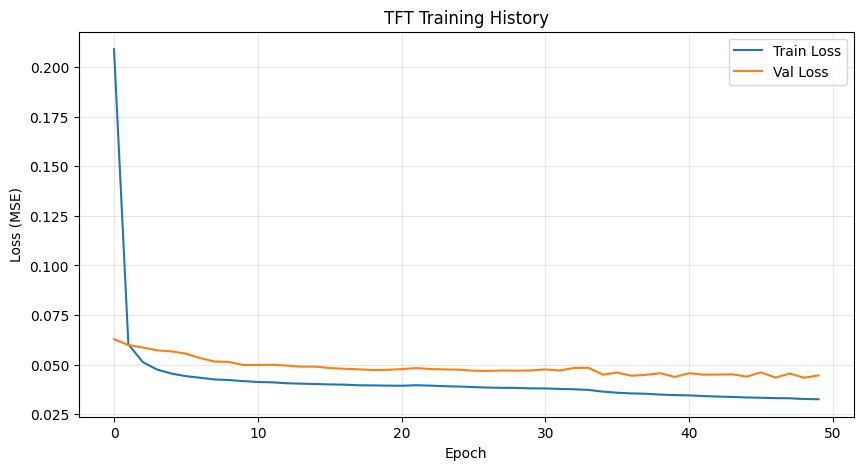

In [140]:
plt.figure(figsize=(10, 5))
plt.plot(history_tft.history['loss'], label='Train Loss')
plt.plot(history_tft.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('TFT Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Prediction vs. Actual 

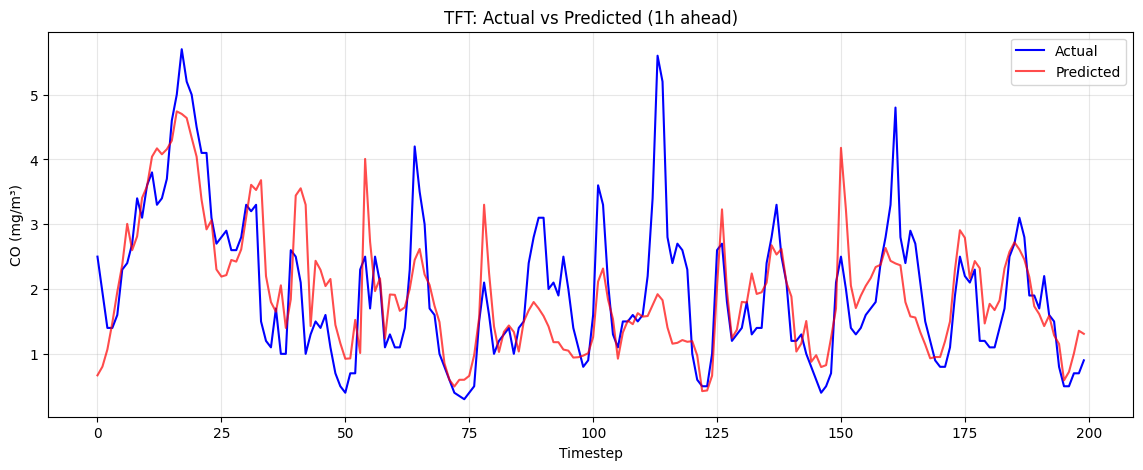

In [141]:
y_true_h1 = y_scaler.inverse_transform(y_test_w[:, 0].reshape(-1, 1)).ravel()
y_pred_h1 = y_scaler.inverse_transform(y_test_point[:, 0].reshape(-1, 1)).ravel()

plt.figure(figsize=(14, 5))
plt.plot(y_true_h1[:200], label='Actual', color='blue')
plt.plot(y_pred_h1[:200], label='Predicted', color='red', alpha=0.7)
plt.xlabel('Timestep')
plt.ylabel('CO (mg/m³)')
plt.title('TFT: Actual vs Predicted (1h ahead)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Evaluation: MAE & RMSE

In [142]:
data = {
    "Model": ["N-BEATSx", "LSTM", "TFT"],
    "Val_MAE":  [val_mae_nb, val_mae, val_mae_tft],
    "Val_RMSE": [val_rmse_nb, val_rmse, val_rmse_tft],
    "Test_MAE": [test_mae_nb, test_mae, test_mae_tft],   
    "Test_RMSE":[test_rmse_nb, test_rmse,test_rmse_tft]
}

print(f"TFT (12h) -> Test MAE: {test_mae_tft:.4f}, RMSE: {test_rmse_tft:.4f}")
df_results = pd.DataFrame(data)
df_results = df_results.sort_values("Val_RMSE")

print(df_results)

TFT (12h) -> Test MAE: 1.0679, RMSE: 1.3572
      Model   Val_MAE  Val_RMSE  Test_MAE  Test_RMSE
1      LSTM  0.815993  1.066559  0.657347   0.825212
0  N-BEATSx  1.000163  1.335707  0.754211   0.963768
2       TFT  1.100380  1.429321  1.067939   1.357214


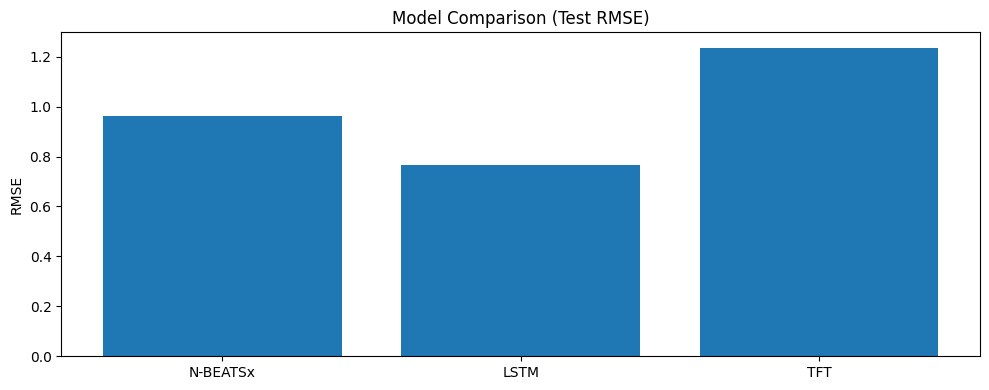

In [111]:
results = pd.DataFrame({
    "Model": ["N-BEATSx", "LSTM", "TFT"],
    "Test RMSE": [test_rmse_nb, test_rmse, test_rmse_tft]
})

plt.figure(figsize=(10, 4))
plt.bar(results["Model"], results["Test RMSE"])
plt.title("Model Comparison (Test RMSE)")
plt.ylabel("RMSE")
plt.tight_layout()
plt.show()